<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos · PEC3</p>
<p style="margin: 0; text-align:right;">2018-1 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Alumno: <b>Fernando Antonio Barbeiro Campos</b> - <a>fbarbeiro@uoc.edu</a></p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 3: Métodos supervisados

En esta práctica veremos diferentes métodos supervisados aplicados sobre el conjunto de datos [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) y trataremos de optimizar diferentes métricas.

<ol start="0">
  <li>Carga de datos</li>
  <li>$k$ vecinos más cercanos</li>
  <li>Support vector machines</li>
  <li>Redes neuronales</li>
  <li>Optimización de métricas</li>
</ol>

**Importante: Cada uno de los ejercicios puede suponer varios minutos de ejecución, por lo que la entrega debe hacerse en formato notebook y en formato html donde se vea el código y los resultados y comentarios de cada ejercicio. Para exportar el notebook a html puede hacerse desde el menú File $\to$ Download as $\to$ HTML.**

## 0. Carga de datos

El conjunto de datos Fashion MNIST proporcionado por Zalando consta de 70.000 imágenes con 10 clases diferentes de ropa repartidas uniformemente. No obstante, para esta práctica utilizaremos únicamente un subconjunto de 5.000 imágenes que consiste en 1.000 imágenes de 5 clases diferentes.

Las imágenes tienen una resolución de 28x28 píxeles en escala de grises, por lo que se pueden representar utilizando un vector de 784 posiciones.

El siguiente código cargará las 5.000 imágenes en la variable images y las correspondientes etiquetas (en forma numérica) en la variable labels. Podemos comprobar que la carga ha sido correcta obteniendo las dimensiones de estas dos variables.

In [1]:
import pickle
import numpy as np

with open("data.pickle", "rb") as f:
    data = pickle.load(f)
    
images = data["images"]
labels = data["labels"]
n_classes = 5
labels_text = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat"]

print("Dimensiones del vector de imágenes: {}".format(images.shape))
print("Dimensiones del vector de etiquetas: {}".format(labels.shape))

Dimensiones del vector de imágenes: (5000, 784)
Dimensiones del vector de etiquetas: (5000,)


Con el siguiente código podemos ver un ejemplo de imagen de cada una de las clases. Para ello reajustamos el vector de 784 dimensiones que representa cada imagen en una matriz de tamaño 28x28 y la transponemos para mostrarla:

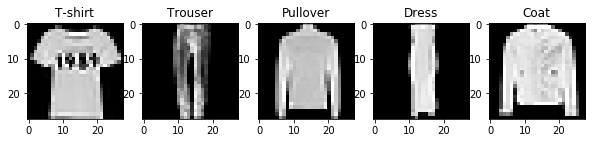

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, n_classes, figsize=(10,10))

idxs = [np.where(labels == i)[0] for i in range(n_classes)]

for i in range(n_classes):
    k = np.random.choice(idxs[i])
    ax[i].imshow(images[k].reshape(28, 28), cmap="gray")
    ax[i].set_title("{}".format(labels_text[i]))

De las 5.000 imágenes distintas utilizaremos 4.000 imágenes para entrenar los diferentes modelos y 1.000 imágenes para validar los resultados. Con el siguiente código separamos los datos que hemos cargado anteriormente en dos conjuntos, train y test, de forma estratificada, es decir, en cada uno de los conjuntos las clases aparecen en la misma proporción que en el conjunto original.

En lugar de trabajar directamente con un vector de 784 dimensiones para cada imagen aplicaremos primero el algoritmo PCA para reducir la dimensión de los ejemplos a 100. El proceso de entrenamiento de PCA lo hacemos con las imágenes de train y luego lo aplicamos también sobre las imágenes de test, de forma que no utilizamos ninguna información de las imágenes en el conjunto de test para entrenar los modelos.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=2017, stratify=labels)

pca = PCA(n_components=100, random_state=2017)
pca_fit = pca.fit(X_train)
X_train_pca = pca_fit.transform(X_train)
X_test_pca = pca_fit.transform(X_test)

def proporcion_etiquetas(y):
    _, count = np.unique(y, return_counts=True)
    return np.true_divide(count, y.shape[0])
    

print("Número de imágenes para entrenar: {}".format(X_train_pca.shape[0]))
print("Número de imágenes para test: {}".format(X_test_pca.shape[0]))

print("Proporción de las etiquetas en el conjunto original: {}".format(proporcion_etiquetas(labels)))
print("Proporción de las etiquetas en el conjunto de entrenamiento: {}".format(proporcion_etiquetas(y_train)))
print("Proporción de las etiquetas en el conjunto de test: {}".format(proporcion_etiquetas(y_test)))

Número de imágenes para entrenar: 4000
Número de imágenes para test: 1000
Proporción de las etiquetas en el conjunto original: [ 0.2  0.2  0.2  0.2  0.2]
Proporción de las etiquetas en el conjunto de entrenamiento: [ 0.2  0.2  0.2  0.2  0.2]
Proporción de las etiquetas en el conjunto de test: [ 0.2  0.2  0.2  0.2  0.2]


## 1. $k$ vecinos más cercanos (2 puntos)

El primer algoritmo que utilizaremos para clasificar las imágenes de ropa es el  $k$-nn. En este ejercicio ajustaremos dos hiperparámetros del algoritmo:

 - $k$: el número de vecinos que se consideran para clasificar un nuevo ejemplo. Probaremos con todos los valores entre 1 y 10.
 - pesos: importancia que se da a cada uno de los vecinos considerados. En este caso probaremos dos opciones: pesos uniformes, donde todos los vecinos se consideran igual; y pesos según distancia, donde los vecinos más cercanos tienen más peso en la clasificación que los vecinos más lejanos.

Para decidir cuáles son los hiperparámetros óptimos utilizaremos una búsqueda de rejilla (grid search), es decir, entrenaremos un modelo para cada combinación de hiperparámetros posible y la evaluaremos utilizando validación cruzada (cross validation) con 4 particiones estratificadas. Posteriormente escogeremos la combinación de hiperparámetros que mejor resultados haya dado.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> cálculo del valor óptimo de los hiperparámetros $k$ y pesos. Podéis utilizar los módulos GridSearchCV y KNeighborsClassifier de sklearn.
</div>

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

k_range = list(range(1, 11)) # Todos los valores entre 1 - 10
weight_options = ['uniform', 'distance'] # pesos uniformes y segun distancia

param_grid = dict(n_neighbors = k_range, weights=weight_options)
print('Posibles parametros: ', param_grid)

knn = KNeighborsClassifier()

# instantiate the grid - from the doc: cv = For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. In all other cases, KFold is used.
grid = GridSearchCV(knn, param_grid, cv = 4, scoring = 'accuracy')

# fit the grid with data
grid.fit(X_train_pca, y_train)

grid.cv_results_

Posibles parametros:  {'weights': ['uniform', 'distance'], 'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}


{'mean_fit_time': array([ 0.0089696 ,  0.00727201,  0.00770521,  0.01038045,  0.00772595,
         0.00777942,  0.00957328,  0.00759131,  0.00814342,  0.00785506,
         0.00768226,  0.00770128,  0.00772458,  0.00751585,  0.01199031,
         0.00800377,  0.01205063,  0.00995028,  0.00875133,  0.00782835]),
 'mean_score_time': array([ 0.17740089,  0.16942692,  0.18702275,  0.22964746,  0.19954753,
         0.19776624,  0.25403607,  0.24288738,  0.22603393,  0.21190286,
         0.21961701,  0.21990299,  0.23029077,  0.23008424,  0.31211996,
         0.29233491,  0.36116856,  0.31270295,  0.25229448,  0.25472349]),
 'mean_test_score': array([ 0.8355 ,  0.8355 ,  0.82525,  0.8355 ,  0.852  ,  0.85375,
         0.84925,  0.85575,  0.8595 ,  0.859  ,  0.854  ,  0.861  ,
         0.857  ,  0.8595 ,  0.8555 ,  0.859  ,  0.85375,  0.85825,
         0.8565 ,  0.85825]),
 'mean_train_score': array([ 1.        ,  1.        ,  0.91883333,  1.        ,  0.92208333,
         1.        ,  0.907333

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué parámetros han dado mejores resultados? ¿Qué variación hay entre las diferentes combinaciones de parámetros? ¿Es significativa la variación entre las diferentes combinaciones? ¿Hay algún parámetro que influya más que el otro? ¿Era de esperar?
</div>

In [5]:
import pandas as pd

warnings.simplefilter(action='ignore', category=FutureWarning)

print('Mejor resultado entre todos los params: ', grid.best_score_)
print('Param que ha generado el score: ', grid.best_params_)
print('Modelo con los mejores params: ', grid.best_estimator_)

#Para contestar las preguntas sobre variación, voy a poner una tabla de dataframe de guia
pd.DataFrame(grid.cv_results_)

Mejor resultado entre todos los params:  0.861
Param que ha generado el score:  {'weights': 'distance', 'n_neighbors': 6}
Modelo con los mejores params:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='distance')


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_neighbors,param_weights,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.008970,0.177401,0.83550,1.000000,1,uniform,"{'weights': 'uniform', 'n_neighbors': 1}",17,0.824,1.000000,0.829,1.000000,0.831,1.000000,0.858,1.000000,0.002587,0.013470,0.013238,0.000000
1,0.007272,0.169427,0.83550,1.000000,1,distance,"{'weights': 'distance', 'n_neighbors': 1}",17,0.824,1.000000,0.829,1.000000,0.831,1.000000,0.858,1.000000,0.000095,0.004409,0.013238,0.000000
2,0.007705,0.187023,0.82525,0.918833,2,uniform,"{'weights': 'uniform', 'n_neighbors': 2}",20,0.825,0.923000,0.810,0.922000,0.825,0.914667,0.841,0.915667,0.000328,0.003947,0.010963,0.003701
3,0.010380,0.229647,0.83550,1.000000,2,distance,"{'weights': 'distance', 'n_neighbors': 2}",17,0.824,1.000000,0.829,1.000000,0.831,1.000000,0.858,1.000000,0.002896,0.076095,0.013238,0.000000
4,0.007726,0.199548,0.85200,0.922083,3,uniform,"{'weights': 'uniform', 'n_neighbors': 3}",15,0.843,0.930000,0.853,0.921000,0.848,0.922333,0.864,0.915000,0.000385,0.004614,0.007778,0.005340
5,0.007779,0.197766,0.85375,1.000000,3,distance,"{'weights': 'distance', 'n_neighbors': 3}",13,0.849,1.000000,0.852,1.000000,0.849,1.000000,0.865,1.000000,0.000563,0.003524,0.006610,0.000000
6,0.009573,0.254036,0.84925,0.907333,4,uniform,"{'weights': 'uniform', 'n_neighbors': 4}",16,0.842,0.911667,0.849,0.908000,0.844,0.906667,0.862,0.903000,0.003135,0.075399,0.007790,0.003100
7,0.007591,0.242887,0.85575,1.000000,4,distance,"{'weights': 'distance', 'n_neighbors': 4}",10,0.847,1.000000,0.857,1.000000,0.855,1.000000,0.864,1.000000,0.000264,0.031591,0.006057,0.000000
8,0.008143,0.226034,0.85950,0.901833,5,uniform,"{'weights': 'uniform', 'n_neighbors': 5}",2,0.861,0.907333,0.865,0.901667,0.845,0.901333,0.867,0.897000,0.000759,0.012101,0.008646,0.003670
9,0.007855,0.211903,0.85900,1.000000,5,distance,"{'weights': 'distance', 'n_neighbors': 5}",4,0.860,1.000000,0.862,1.000000,0.845,1.000000,0.869,1.000000,0.000510,0.003830,0.008746,0.000000


El mejor resultado ha sido **0.861** y los parametros que lo han generado son:
 - Peso: **según distancia**
 - Número de vecinos: **6**

La variación mas grande que hay está entre el par **{2, uniforme}** para el mejor resultado **{6, distancia}** en la respectiva magnitud de **0.82525** vs **0.861**. Desde mi punto de vista, la verdad es que la variación entre la gran mayoría de las combinaciones es bastante pequeña quedando **casi** todas arriba de un *umbral* de 0.85~ y solamente el mejor resultado supera los 0.86 siendo significativa.

Considerando la variación entre el KNN con **número de vecinos = 6** y los pesos *uniform* y *distance* podemos inferir que los pesos tiene un papel importante que potencialmente influye más a la hora de elegir el mejor resultado. Creo que el cambio de valor al puntuar la calidad del modelo por *distance* (o sea, vecinos más cercanos tiene valor más relevante) hace con que sea un comportamiento esperado. Por último, a titulo de curiosidad, he ejecutado el mismo algoritmo sin pasar los pesos y el mejor resultado fue con 5 vecinos.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> entrenar un modelo $k$-nn con los valores de los hiperparámetros óptimos utilizando todo el conjunto *X_train_pca* y mostrar la precisión de la predicción del modelo en el conjunto *X_test_pca*.
</div>

In [6]:
from sklearn.metrics import accuracy_score
knn = KNeighborsClassifier(n_neighbors=6, weights='distance')

knn.fit(X_train_pca, y_train)

y_pred = knn.predict(X_test_pca)
print('Precisión de la predicción del modelo en el conjunto = {}'.format(accuracy_score(y_test, y_pred)))

Precisión de la predicción del modelo en el conjunto = 0.866


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> mostrar la matriz de confusión del modelo y algunas imágenes que el modelo haya clasificado incorrectamente junto con la etiqueta asignada por el modelo y la etiqueta original.
</div>

Tamaño igual de samples: 1000
La cantidad de errores es:  134
{'Clasificación Correcta': 'Trouser', 'Clasificación Equivocada': 'Pullover', 'Indice del error': 373}
{'Clasificación Correcta': 'Coat', 'Clasificación Equivocada': 'Dress', 'Indice del error': 223}
{'Clasificación Correcta': 'Coat', 'Clasificación Equivocada': 'Pullover', 'Indice del error': 716}
{'Clasificación Correcta': 'T-shirt', 'Clasificación Equivocada': 'Dress', 'Indice del error': 369}
{'Clasificación Correcta': 'Pullover', 'Clasificación Equivocada': 'Coat', 'Indice del error': 837}
{'Clasificación Correcta': 'Dress', 'Clasificación Equivocada': 'T-shirt', 'Indice del error': 636}
{'Clasificación Correcta': 'Pullover', 'Clasificación Equivocada': 'Coat', 'Indice del error': 495}
{'Clasificación Correcta': 'Dress', 'Clasificación Equivocada': 'T-shirt', 'Indice del error': 138}


,T-shirt,Trouser,Pullover,Dress,Coat
True T-shirt,178,0,12,8,2
True Trouser,1,194,3,2,0
True Pullover,2,0,160,2,36
True Dress,11,0,2,181,6
True Coat,2,0,34,11,153


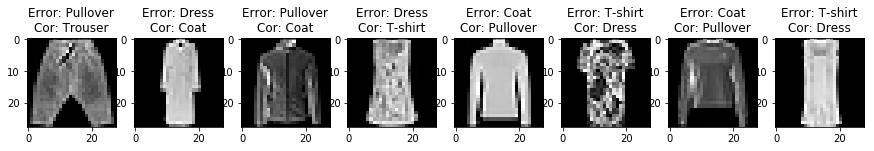

In [7]:
from sklearn.metrics import confusion_matrix
import random

labels_confusion = ['True ' + s for s in labels_text]

def my_confusion_matrix (y_result_pred) :
    return pd.DataFrame(
        confusion_matrix(y_test, y_result_pred),
        columns = labels_text,
        index = labels_confusion
    )

def print_wrong_classification (max_value, y_result_pred) :
    wrong_list = []

    if len(y_test) == len(y_result_pred):
        print("Tamaño igual de samples: " + str(len(y_test)))

        for i in range(len(y_test)):
            if y_test[i] != y_result_pred[i]:
                wrong_list.append({'Indice del error': i
                                   , 'Clasificación Equivocada': labels_text[y_result_pred[i]]
                                   , 'Clasificación Correcta': labels_text[y_test[i]]
                                  })
    print('La cantidad de errores es: ', len(wrong_list))


    fig, ax = plt.subplots(1, max_value, figsize=(15,15))

    for i in range(max_value):
        k = random.sample(wrong_list, 1)[0]
        print(k)
        #Using X_test instead of X_test_pca in order to view better images
        ax[i].imshow(X_test[k['Indice del error']].reshape(28, 28), cmap="gray")
        ax[i].set_title('Error: {}\nCor: {}'.format(k['Clasificación Equivocada'], k['Clasificación Correcta']))

# Enseñando simplemente 8 imagenes
max_value = 8
print_wrong_classification(max_value, y_pred)
my_confusion_matrix(y_pred)


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Cómo son los errores? ¿Parecen razonables?
</div>

Obserbando arriba la matriz de confusión y también las imagenes que fueron clasificadas de manera incorreta, mi conclusión es que los errores fueron completamente razonables.

Por ejemplo: 
 - en las categorías de **pantalones**, donde las imagenes son significativamente diferentes de las demás, la **cantidad de errores fue bastante pequeña**. 
 - La distinción entre *pullover* y *coat* que parece ser dificil de encontrar incluso para una mirada humana (en las imagenes), explica que haya un poco más de imprecisión entre separar las dos categorías.
 - Lo mismo ocurre al separar *T-Shirt* de *Dress*, aunque haya algunos donde la distinción es clara, hay imagenes que dejan margen para dudas. La misma cuestión puede ser aplicada entre *T-Shirts y pullovers*, por ejemplo.

Al final, creo que el resultado ha sido **bastante efectivo y razonable**.



## 2. Support Vector Machines (2 puntos)

En este segundo ejercicio clasificaremos las imágenes de ropa utilizando el algoritmo SVM con el kernel radial. En este caso, en lugar de utilizar una búsqueda de rejilla para ajustar los hiperparámetros del algoritmo utilizaremos una búsqueda aleatoria, es decir, probaremos combinaciones de parámetros al azar. Los hiperparámetros a optimizar son:

- C: el valor de penalización de los errores en la clasificación. Marca el compromiso entre obtener el hiperplano con el mayor margen posible y clasificar el máximo número de ejemplos correctamente. Probaremos valores aleatorios distribuidos uniformemente entre 1 y 500.
- gamma: coeficiente que multiplica la distancia entre dos puntos en el kernel radial. Probaremos valores aleatorios distribuidos uniformemente entre 0.001 y 0.1

Igual que en el caso anterior, para validar el rendimiento del algoritmo con cada combinación de hiperparámetros utilizaremos validación cruzada (cross-validation) con 4 particiones estratificadas.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> cálculo del valor óptimo de los hiperparámetros C y gamma utilizando 10 combinaciones de parámetros elegidas al azar. Podéis utilizar los módulos RandomizedSearchCV y svm de sklearn, así como el módulo uniform de scipy.
</div>

In [8]:
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.svm import SVC as svc 
from scipy import stats

stf_partition = 4
rand_list = {"C": stats.uniform(1, 500),
             "gamma": stats.uniform(0.001, 0.1)}

svm = svc(kernel='rbf', probability = True, random_state = 1)
# cv param: - integer, to specify the number of folds in a `(Stratified)KFold`,
# n_jobs param: could have use it to speed up - it represents Number of jobs to run in parallel - default None
rand_search = RandomizedSearchCV(svm, param_distributions = rand_list, n_iter = 10, cv = stf_partition, random_state = 2017) 
rand_search.fit(X_train_pca, y_train)
rand_search.cv_results_

{'mean_fit_time': array([ 7.77874202,  2.7189638 ,  6.31751788,  3.29738605,  3.34705079,
         5.81265962,  3.58515018,  3.46736467,  2.47057176,  6.60589921]),
 'mean_score_time': array([ 0.32119948,  0.18017238,  0.25087965,  0.18927652,  0.21694493,
         0.25264549,  0.19829381,  0.19195366,  0.16452825,  0.25747305]),
 'mean_test_score': array([ 0.8755 ,  0.87125,  0.88025,  0.88   ,  0.88175,  0.88125,
         0.88375,  0.88325,  0.87425,  0.87675]),
 'mean_train_score': array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]),
 'param_C': masked_array(data = [11.480112703058708 224.95989990030108 466.38648054349306 71.33553010850602
  114.23764531929731 57.436125163790543 194.65406682967895
  316.44529707729237 473.43226456934565 39.084503770289658],
              mask = [False False False False False False False False False False],
        fill_value = ?),
 'param_gamma': masked_array(data = [0.077707016468248791 0.013054161556730448 0.065955041044239618
  0.0241594337

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué parámetros han dado mejores resultados? ¿Qué variación hay entre las diferentes combinaciones de parámetros? ¿Es significativa la variación entre las diferentes combinaciones? ¿Hay algún parámetro que influya más que el otro? ¿Era de esperar?
</div>

In [9]:
print('Mejor resultado entre todos los params: ', rand_search.best_score_)
print('Param que ha generado el score: ', rand_search.best_params_)
print('Modelo con los mejores params: ', rand_search.best_estimator_)

#Para contestar las preguntas sobre variación, voy a poner otra vez una tabla de dataframe de guia
pd.DataFrame(rand_search.cv_results_)

Mejor resultado entre todos los params:  0.88375
Param que ha generado el score:  {'C': 194.65406682967895, 'gamma': 0.032624562059564634}
Modelo con los mejores params:  SVC(C=194.65406682967895, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.032624562059564634,
  kernel='rbf', max_iter=-1, probability=True, random_state=1,
  shrinking=True, tol=0.001, verbose=False)


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_gamma,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,7.778742,0.321199,0.87550,1.0,11.4801,0.077707,"{'C': 11.4801127031, 'gamma': 0.0777070164682}",8,0.859,1.0,0.881,1.0,0.878,1.0,0.884,1.0,0.627035,0.051783,0.009760,0.0
1,2.718964,0.180172,0.87125,1.0,224.96,0.0130542,"{'C': 224.9598999, 'gamma': 0.0130541615567}",10,0.856,1.0,0.877,1.0,0.874,1.0,0.878,1.0,0.168343,0.023305,0.008927,0.0
2,6.317518,0.250880,0.88025,1.0,466.386,0.065955,"{'C': 466.386480543, 'gamma': 0.0659550410442}",5,0.864,1.0,0.886,1.0,0.879,1.0,0.892,1.0,0.673563,0.002789,0.010449,0.0
3,3.297386,0.189277,0.88000,1.0,71.3355,0.0241594,"{'C': 71.3355301085, 'gamma': 0.0241594337548}",6,0.863,1.0,0.885,1.0,0.882,1.0,0.890,1.0,0.226833,0.005219,0.010223,0.0
4,3.347051,0.216945,0.88175,1.0,114.238,0.0270055,"{'C': 114.237645319, 'gamma': 0.0270054945349}",3,0.865,1.0,0.886,1.0,0.885,1.0,0.891,1.0,0.208722,0.021170,0.009934,0.0
5,5.812660,0.252645,0.88125,1.0,57.4361,0.0641905,"{'C': 57.4361251638, 'gamma': 0.0641904839966}",4,0.865,1.0,0.888,1.0,0.880,1.0,0.892,1.0,0.046585,0.005007,0.010329,0.0
6,3.585150,0.198294,0.88375,1.0,194.654,0.0326246,"{'C': 194.65406683, 'gamma': 0.0326245620596}",1,0.871,1.0,0.886,1.0,0.887,1.0,0.891,1.0,0.036631,0.006067,0.007595,0.0
7,3.467365,0.191954,0.88325,1.0,316.445,0.0304651,"{'C': 316.445297077, 'gamma': 0.0304651081289}",2,0.867,1.0,0.886,1.0,0.888,1.0,0.892,1.0,0.031957,0.000633,0.009627,0.0
8,2.470572,0.164528,0.87425,1.0,473.432,0.0161626,"{'C': 473.432264569, 'gamma': 0.0161625713097}",9,0.857,1.0,0.880,1.0,0.880,1.0,0.880,1.0,0.025885,0.001224,0.009959,0.0
9,6.605899,0.257473,0.87675,1.0,39.0845,0.071391,"{'C': 39.0845037703, 'gamma': 0.0713909606664}",7,0.862,1.0,0.884,1.0,0.875,1.0,0.886,1.0,0.129438,0.005078,0.009470,0.0


La variación es bastante pequeña entre las combinaciones (en la primera ejecución sobre la cual hago el analisis), era en la tasa de **0.0125** entre el mejor y el peor resultado de los parametros.

Dos definiciones rapidas antes de definir parámetro que influya más:

 - C es el coste de la clasificación errónea: 
     - **C grande = sesgo bajo y varianza alta**. **C pequeña = mayor sesgo y menor varianza**.

 - Gamma es el parámetro de un kernel gaussiano:
     - **gamma grande = sesgo alto y una varianza baja**. **gamma pequeño = sesgo bajo y una varianza alta**.

Una vez dicho esto y sin más preámbulos: el comportamiento del modelo es más sensible al parámetro gamma. Y en escenários, la regularización con C podrá evitar el *overfitting*.

Comparando los 2 modelos **SVM** vs **KNN** utilizo una frase de *Géron, 2019 (early release) Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition* para apoyar que era esperado mejor comportamiento en SVM:

<div style="background-color: #fff9ba; border-color: #bcb34b; border-left: 5px solid #f4e542; padding: 0.5em;">
<i>A Support Vector Machine (SVM) is a very powerful and versatile Machine Learning model, capable of performing linear or nonlinear classification, regression, and even outlier detection. It is one of the most popular models in Machine Learning, and anyone interested in Machine Learning should have it in their toolbox. SVMs are particularly well suited for classification of complex but small- or medium-sized datasets.</i>
</div>


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> entrenar un modelo SVM con los valores de los hiperparámetros óptimos utilizando todo el conjunto *X_train_pca* y mostrar la precisión de la predicción del modelo en el conjunto *X_test_pca*.
</div>

In [10]:
clf = svc(kernel='rbf', C = rand_search.best_params_['C'], gamma = rand_search.best_params_['gamma'])
clf.fit(X_train_pca, y_train)

y_SVM_pred = clf.predict(X_test_pca)
print('Precisión de la predicción del modelo SVM en el conjunto = {}'.format(accuracy_score(y_test, y_SVM_pred)))

Precisión de la predicción del modelo SVM en el conjunto = 0.875


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> mostrar la matriz de confusión del modelo y algunas imágenes que el modelo haya clasificado incorrectamente junto con la etiqueta asignada por el modelo y la etiqueta original.
</div>

Tamaño igual de samples: 1000
La cantidad de errores es:  125
{'Clasificación Correcta': 'Pullover', 'Clasificación Equivocada': 'Coat', 'Indice del error': 503}
{'Clasificación Correcta': 'Dress', 'Clasificación Equivocada': 'Trouser', 'Indice del error': 932}
{'Clasificación Correcta': 'Coat', 'Clasificación Equivocada': 'Pullover', 'Indice del error': 833}
{'Clasificación Correcta': 'Coat', 'Clasificación Equivocada': 'Pullover', 'Indice del error': 75}
{'Clasificación Correcta': 'Trouser', 'Clasificación Equivocada': 'T-shirt', 'Indice del error': 893}
{'Clasificación Correcta': 'Dress', 'Clasificación Equivocada': 'T-shirt', 'Indice del error': 904}
{'Clasificación Correcta': 'Coat', 'Clasificación Equivocada': 'Pullover', 'Indice del error': 891}
{'Clasificación Correcta': 'Pullover', 'Clasificación Equivocada': 'Coat', 'Indice del error': 608}


,T-shirt,Trouser,Pullover,Dress,Coat
True T-shirt,181,0,7,11,1
True Trouser,1,196,1,2,0
True Pullover,3,0,162,2,33
True Dress,12,5,5,173,5
True Coat,1,0,23,13,163


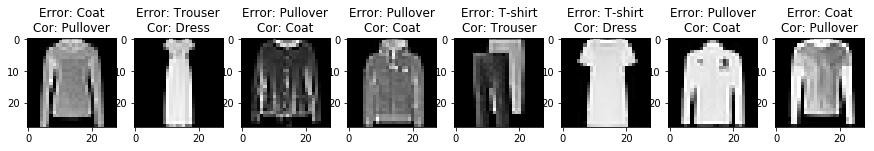

In [11]:
# max_value already defined = 8
print_wrong_classification(max_value, y_SVM_pred)
my_confusion_matrix(y_SVM_pred)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Cómo son los errores? ¿Parecen razonables?
</div>

La calidad del modelo ha **aumentado o sea, hay menos errores**, con lo que queda claro la eficiencia del SVM. Sigue habiendo una clara dificuldad de separar *Pullover* y *Coat*, pero considero dificil de ser discernible a simple vista por humanos, por lo tanto, otra vez son completamente razonables los errores.

## 3. Redes neuronales (4 puntos)

Como tercer ejercicio utilizaremos una red neuronal para clasificar las imágenes de ropa. Utilizaremos también ahora una búsqueda aleatoria para ajustar los hiperparámetros de la red neuronal. En particular, utilizaremos una red monocapa con ~~4 salidas~~ 5 salidas (una para cada clase del conjunto de datos) entrenada con el método de retropropagación y el optimizador SGD. Las neuronas de la capa oculta tendrán como activación la función sigmoide. Los hiperparámetros a ajustar en este caso son los siguientes:

- Número de neuronas de la capa oculta: probaremos valores entre 20 y 200.
- Número de épocas de entrenamiento: probaremos valores entre 10 y 50.
- Velocidad de aprendizaje (learning rate): probaremos valores entre 0.001 y 0.2.

El procedimiento para validar el rendimiento del modelo para cada combinación de parámetros será el mismo que en los casos anteriores: validación cruzada con 4 particiones generadas de forma estratificada.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> cálculo del valor óptimo del número de neuronas de la capa oculta, el número de épocas de entrenamiento y la velocidad de aprendizaje utilizando 10 combinaciones de parámetros elegidas al azar. Podéis utilizar los módulos Sequential, Dense y SGD de keras, además de uniform y randint de scipy y StratifiedKFold de sklearn.
</div>

In [67]:
from keras.utils import np_utils

NB_CLASSES = 5

# One hot enconded
y_train_he = np_utils.to_categorical(y_train, NB_CLASSES)
y_test_he = np_utils.to_categorical(y_test, NB_CLASSES)


(4000, 784)

In [64]:
import numpy
import random
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

def create_model(nodes=20, lr=0.001):
    print("Node: {} /Learning Rate: {} ".format(nodes, lr))
    model = Sequential()
    model.add(Dense(nodes, kernel_initializer='uniform', input_dim=100))
    model.add(Activation('relu'))
    model.add(Dense(NB_CLASSES))
    model.add(Activation('softmax'))

    opt = SGD(lr=lr)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt, metrics=['accuracy'])

    return(model)

stf_partition = 4
rand_list = {"nodes": random.randint(20, 200), # Hidden layer
             "lr": random.uniform(0.001, 0.2),
             "batch_size": 64,
             "epochs": random.randint(10, 50)}
print(rand_list)
rand_search = RandomizedSearchCV(estimator=create_model(), param_distributions = rand_list, n_iter = 10, cv = 4, random_state = 2017, scoring = 'accuracy') 
print(rand_search)
rand_search.fit(X_train_pca, y_train_he)
rand_search.cv_results_


{'batch_size': 64, 'epochs': 40, 'nodes': 160, 'lr': 0.1627881275773808}
Node: 20 /Learning Rate: 0.001 
RandomizedSearchCV(cv=4, error_score='raise',
          estimator=<keras.engine.sequential.Sequential object at 0x7fa93ef53a20>,
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'batch_size': 64, 'epochs': 40, 'nodes': 160, 'lr': 0.1627881275773808},
          pre_dispatch='2*n_jobs', random_state=2017, refit=True,
          return_train_score=True, scoring='accuracy', verbose=0)


TypeError: object of type 'int' has no len()

In [38]:
y_train_he

array([[ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.]], dtype=float32)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué parámetros han dado mejores resultados? ¿Qué variación hay entre las diferentes combinaciones de parámetros? ¿Es significativa la variación entre las diferentes combinaciones? ¿Hay algún parámetro que influya más que los otros? ¿Era de esperar?
</div>

In [16]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.805000 using {'batch_size': 10, 'epochs': 50}
0.780250 (0.007049) with: {'batch_size': 10, 'epochs': 10}
0.777000 (0.011811) with: {'batch_size': 10, 'epochs': 20}
0.604000 (0.021920) with: {'batch_size': 10, 'epochs': 30}
0.748000 (0.013583) with: {'batch_size': 10, 'epochs': 40}
0.805000 (0.018344) with: {'batch_size': 10, 'epochs': 50}
0.721500 (0.011927) with: {'batch_size': 20, 'epochs': 10}
0.774250 (0.016254) with: {'batch_size': 20, 'epochs': 20}
0.680000 (0.090565) with: {'batch_size': 20, 'epochs': 30}
0.730750 (0.012153) with: {'batch_size': 20, 'epochs': 40}
0.767500 (0.026043) with: {'batch_size': 20, 'epochs': 50}
0.611500 (0.057821) with: {'batch_size': 40, 'epochs': 10}
0.624000 (0.056343) with: {'batch_size': 40, 'epochs': 20}
0.738250 (0.063845) with: {'batch_size': 40, 'epochs': 30}
0.743000 (0.024135) with: {'batch_size': 40, 'epochs': 40}
0.640000 (0.079202) with: {'batch_size': 40, 'epochs': 50}
0.647500 (0.030615) with: {'batch_size': 60, 'epochs': 10}
0.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> entrenar una red neuronal con los valores de los hiperparámetros óptimos utilizando todo el conjunto *X_train_pca* y mostrar la precisión de la predicción del modelo en el conjunto *X_test_pca*.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> mostrar la matriz de confusión del modelo y algunas imágenes que el modelo haya clasificado incorrectamente junto con la etiqueta asignada por el modelo y la etiqueta original.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Cómo son los errores? ¿Parecen razonables?
</div>

## 4. Optimización de métricas (2 puntos)

En los ejercicios anteriores hemos buscado siempre el modelo que mejor precisión obtiene en general, pero esto no es siempre los más adecuado. Por ejemplo, imaginemos que necesitamos el modelo para una empresa que únicamente vende pantalones y está haciendo un estudio sobre las imágenes de pantalones que obtiene de Internet. En este escenario, imaginemos que la empresa quiere estudiar el máximo número posible de imágenes de pantalones, por lo que está muy interesada en que el modelo no clasifique erróneamente imágenes de pantalones (asumiendo si es necesario que para ello habrá imágenes clasificadas como pantalones que en realidad no lo sean).

La misma idea de utilidad del modelo se puede encontrar, aunque con un ejemplo más complejo, en [este enlace](http://blog.mldb.ai/blog/posts/2016/01/ml-meets-economics/).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Definir una función que, dada la predicción del modelo para un conjunto de imágenes y las etiquetas reales de los datos, devuelva un coste de forma que los errores de clasificar un pantalón como otra prenda tengan el doble de peso que los otros errores.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Utilizar la función definida anteriormente junto con el código de entrenamiento de la red neuronal para optimizar los hiperparámetros de la red según la nueva métrica.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Han cambiado significativamente los mejores valores de los hiperparámetros? ¿Cuál crees que puede ser la razón?
</div>